# Plant Disease Classification

Dataset [link](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(tf.__version__)

2.6.4


### Using GPU if availbale

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
physical_devices = tf.config.list_physical_devices("GPU")
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

### MirroredStrategy

MirroredStrategy is a method that you can use to perform synchronous distributed training across multiple GPUs. Using this method, you can create replicas of your model variables which are mirrored across your GPUs.

In [5]:
strategy = tf.distribute.MirroredStrategy()
strategy.num_replicas_in_sync

2

In [6]:
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [7]:
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Folder and Files

Description:
1. Training folder and validation folder
2. Test folder

In [8]:
TRAIN_PATH = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
VALID_PATH = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'
IMAGE_SIZE = 256

#### tf.data.Dataset

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:##### The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(TRAIN_PATH, shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
valid_ds = tf.keras.utils.image_dataset_from_directory(VALID_PATH, shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


# Info about Dataset

This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

[source](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)

In [10]:
train_class_names = train_ds.class_names
valid_class_names = valid_ds.class_names

print(len(train_class_names))
print(len(valid_class_names))

38
38


In [11]:
n_classes = 38

In [12]:
import pandas as pd
train_class_df = pd.Series(train_class_names)
train_class_df.head()

0          Apple___Apple_scab
1           Apple___Black_rot
2    Apple___Cedar_apple_rust
3             Apple___healthy
4         Blueberry___healthy
dtype: object

### More Description

- Every Batch contains set of images with Image and its label
- Dimmensions of each image → 256x256x3(RGB)

In [13]:
train_ds_iterator = train_ds.as_numpy_iterator()

batch = train_ds_iterator.next()
print(type(batch))

 # img and label -> len = 2
print(len(batch))

<class 'tuple'>
2


In [14]:
# Every Batch shape
print("Dimmensions of the Batch:",batch[0].shape)
# batch[0] gives a numpy array
print("Size of Batch:",len(batch[0])) #1 batch 32 image/ matrices
print(batch[1]) # labels
# size of labels
print("No of Labels:",len(batch[1]))

Dimmensions of the Batch: (64, 256, 256, 3)
Size of Batch: 64
[ 8 29  9 31 35 10 35  6  1  6 14  3  3 33 23  1 31 24 12 14 10 31 21 29
 23 36 18 29 13 31 32 23 37  6 16  7  5 19 29 21 30 12  9  8 15 24 17 32
 36 17  9 33 34  5 17 32 29 12  4 34 26  4 20 29]
No of Labels: 64


### Accessing them via iteration ->tf.data.Dataset
##### 1. take()
##### 2. enumeration()

In [15]:
for image_batch, label in train_ds.take(1):
    print(image_batch.shape)
    print(image_batch[0].shape)
    print(label.shape)

(64, 256, 256, 3)
(256, 256, 3)
(64,)


In [16]:
for batch_idx, (x_batch, y_batch) in enumerate(train_ds):
    print(batch_idx)
    print(x_batch.shape)
    print(x_batch[0].shape)
    print(y_batch)
    break

0
(64, 256, 256, 3)
(256, 256, 3)
tf.Tensor(
[34 33 36 10 20  5 18 10 30  4 21 30  6 21  2 12  1 28 12 14 15  6  6  0
 10 30  5 14  4 12 37 25 25  6  8 33 26 37 32  7 33  4 23 29 31  1 17 22
 24 35  8 32  0 27  8 29 22 24 26 36  8 28 16 21], shape=(64,), dtype=int32)


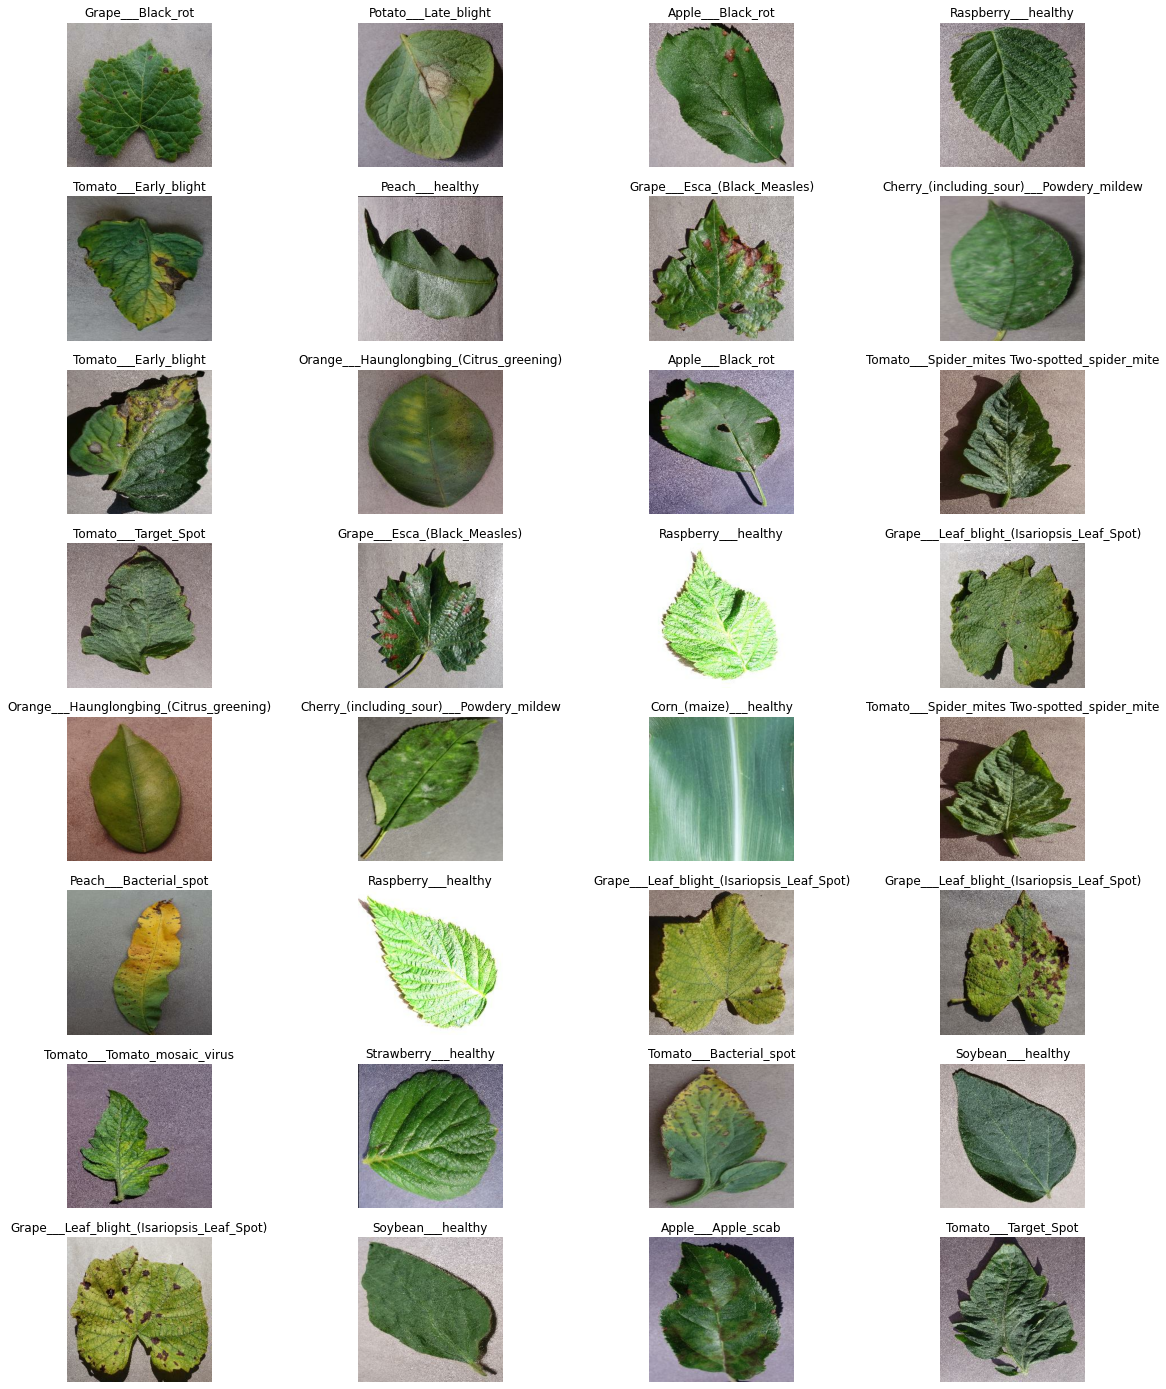

In [17]:
plt.figure(figsize=(20,25))
for images, labels in train_ds.take(1): # can also be done via enumeration (tf.data.dataset)
    for i in range(BATCH_SIZE_PER_REPLICA):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels[i]])
        plt.axis("off")

### some optimizing stuff!
We need sufficient RAM For them to work

#### 1. Caching
The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

In [18]:
# train_ds = train_ds.cache()
# valid_ds = valid_ds.cache()

#### 2. Prefetch

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [19]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

# Architecture

This projecrs follows the RestNet-9 Architecture as suggested by the following [research paper](https://www.researchgate.net/figure/ResNet-9-architecture-A-convolutional-neural-net-with-9-layers-and-skip-connections_fig1_363585139)

### Subclassing API

Model and its Layers are built using the concept of SubClassing in tensorflow.
- Custom Layer using Layers class (tf.keras.layers.Layers)
- Custom Model using Model class (tf.keras.Model)

In [20]:
import tensorflow.keras.layers as Layers

In [21]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Layer, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)

### Convolution block

Contains
- Convolution Layer
- BatchNormalization Layer
- Relu activation function upon
- MaxPooling Layer

In [23]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, maxpool = False):
        super(ConvBlock, self).__init__()
        self.maxpool = maxpool
        
        self.conv = Conv2D(filters, kernel_size=(3,3), strides = 1, padding = 'same')
        self.bn = BatchNormalization()
        self.maxPoolLayer = MaxPool2D(pool_size = 4)
    
    def call(self, input_tensor, training = False):
        x = self.conv(input_tensor)
        x = self.bn(x, training = training)
        x = tf.nn.relu(x)
        if self.maxpool == True:
            x = self.maxPoolLayer(x)
        return x

### Resnet Model

Contains sequence of Convolutional blocks and some skip connections in between

In [24]:
class ResNet9(tf.keras.Model):
    def __init__(self, input_channels=3, n_classes = n_classes):
        super(ResNet9, self).__init__()
    
        self.conv1 = ConvBlock(64)
        self.conv2 = ConvBlock(128, maxpool=True)
        
        self.conv3 = ConvBlock(128)
        self.conv4 = ConvBlock(128)
        
        #self.res1 = Layers.add([self.conv3, self.conv4])
        
        self.conv5 = ConvBlock(256, maxpool=True)
        self.conv6 = ConvBlock(512, maxpool=True)
        
        self.conv7 = ConvBlock(512)
        self.conv8 = ConvBlock(512)
        
        #self.res2 = layers.add([self.conv7, self.conv8])
        
        self.maxpool2d = MaxPool2D(4)
        
        self.flatten = Flatten()
        
        self.dense1 = Dense(n_classes)
        self.globalAvgPool = GlobalAveragePooling2D()
        self.dropout = Dropout(0.2)
        
        self.classifier = Sequential([
            self.maxpool2d,
            self.globalAvgPool,
            self.flatten,
            self.dropout,
            self.dense1,
        ])
        
    def call(self, xbatch):
        op = self.conv1(xbatch)
        op = self.conv2(op)
        res_op1 = op
        
        op = self.conv3(op)
        op = self.conv4(op)
        op = Layers.add([op, res_op1])

        op = self.conv5(op)
        op = self.conv6(op)
        res_op2 = op
        
        op = self.conv7(op)
        op = self.conv8(op)
        op = Layers.add([op, res_op2])
        
        op = self.classifier(op)
        
        return op
    
    # custom function to print summary
    def build_summary(self, input_shape=(256,256,3)):
        x = tf.keras.layers.Input(shape = input_shape)
        return keras.Model(inputs = [x], outputs = self.call(x))

Optimizers and Loss functions

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

method *build_summary* is defined to view the summary in more microscopic way since the Subclassing API displays everything @ Block level.

In [26]:
ResNet9().build_summary().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, 256, 256, 64) 2048        input_1[0][0]                    
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, 64, 64, 128)  74368       conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_2 (ConvBlock)        (None, 64, 64, 128)  148096      conv_block_1[0][0]               
______________________________________________________________________________________________

### Final Decisions

- After many tries it has been observed that the accuracy jumps away from the global minima after 2nd epoch thus Learning rate is adjusted by using the following function.
- Also 3/4 epochs were sufficeint for the optimal model.

In [27]:
EPOCHS = 4

In [28]:
def decay(epoch):
    if epoch < 2:
        return 1e-3
    elif epoch >= 2:
        return 1e-4

In [29]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay),
]

The Following code is scoped with Mirrored Stratrgy above to effectively use the power of multiple CPUS available.

In [30]:
%%time
with strategy.scope():

    resnet9 = ResNet9()
    resnet9.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy']
    )
    
    hist = resnet9.fit(train_ds, batch_size=BATCH_SIZE, validation_data=valid_ds, epochs = EPOCHS, verbose=1, callbacks=callbacks)

Epoch 1/4
1099/1099 [==============================] - 574s 502ms/step - loss: 0.8907 - accuracy: 0.7607 - val_loss: 0.5597 - val_accuracy: 0.8386
Epoch 2/4
1099/1099 [==============================] - 579s 526ms/step - loss: 0.2125 - accuracy: 0.9334 - val_loss: 0.5200 - val_accuracy: 0.8548
Epoch 3/4
1099/1099 [==============================] - 549s 499ms/step - loss: 0.0583 - accuracy: 0.9809 - val_loss: 0.0229 - val_accuracy: 0.9922
Epoch 4/4
1099/1099 [==============================] - 549s 499ms/step - loss: 0.0405 - accuracy: 0.9869 - val_loss: 0.0266 - val_accuracy: 0.9923
CPU times: user 19min 56s, sys: 7min 22s, total: 27min 19s
Wall time: 37min 44s


### ⬆️⬆️Accuracy over ~99% is acheived

In [31]:
resnet9.evaluate(valid_ds)

275/275 [==============================] - 52s 186ms/step - loss: 0.0266 - accuracy: 0.9921


[0.0265597403049469, 0.9921466112136841]

In [32]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

Learning Rates across the epochs

In [33]:
hist.history['lr']

[0.001, 0.001, 1e-04, 1e-04]

In [34]:
hist.history['val_accuracy']

[0.8386068940162659,
 0.8548258543014526,
 0.9922035336494446,
 0.9922603964805603]

# Visualizing the results

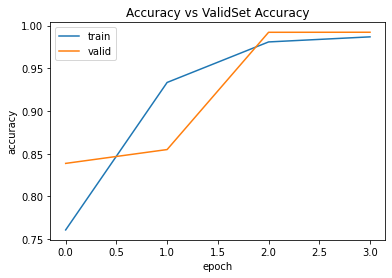

In [35]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy vs ValidSet Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

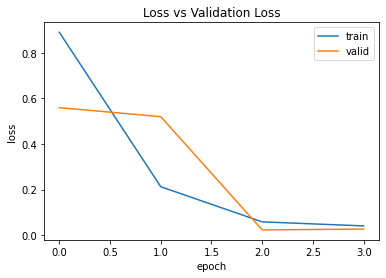

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Predictions

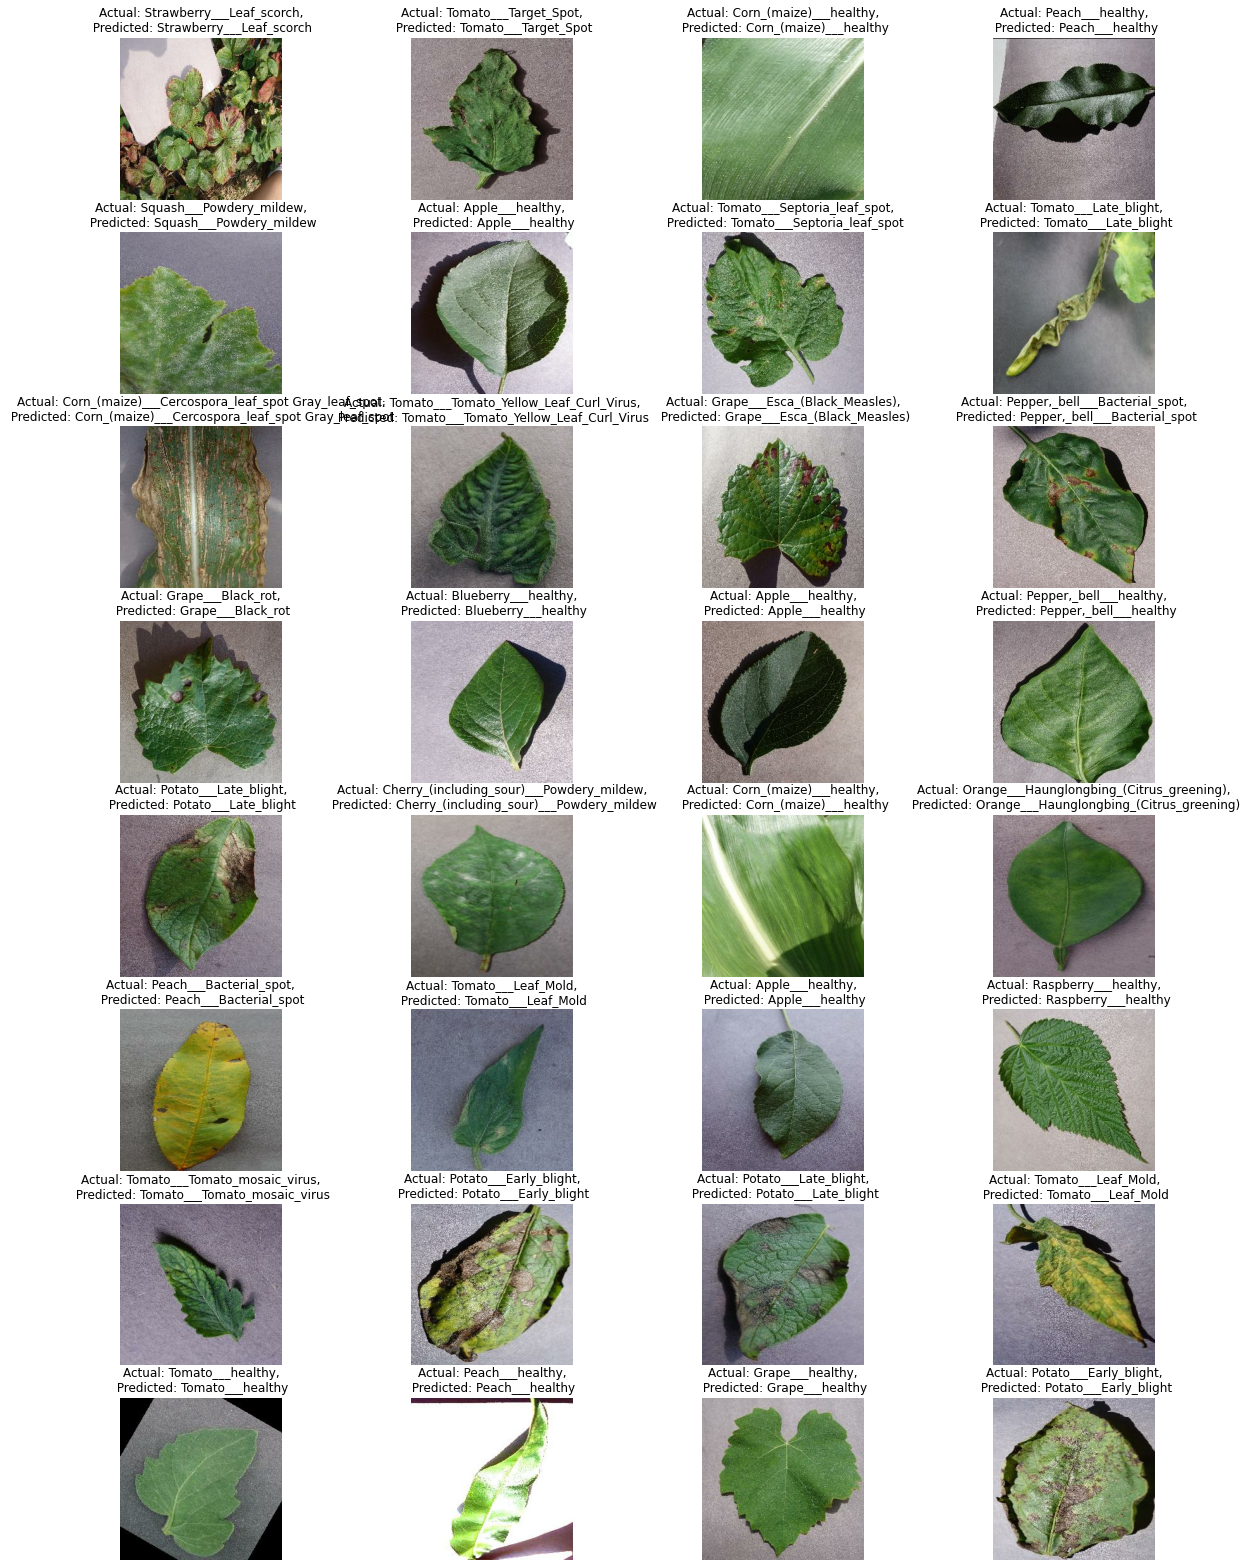

In [37]:
plt.figure(figsize=(20, 28))
for images, labels in valid_ds.take(1):
    for i in range(BATCH_SIZE_PER_REPLICA):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class = train_class_names[labels[i]]
        
        img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_arr = tf.expand_dims(img_arr, 0)
        
        batch_prediction = resnet9.predict(img_arr)
        predicted_class = train_class_names[np.argmax(batch_prediction[0])]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        plt.axis("off")


# Testing

In [38]:
TEST_PATH = '/kaggle/input/new-plant-diseases-dataset/test/'

In [39]:
test_images = sorted(os.listdir(TEST_PATH + '/test'))

In [40]:
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [41]:
test_labels = [x.split('.')[0][:-1] for x in test_images]

In [42]:
test_ds = tf.keras.utils.image_dataset_from_directory(TEST_PATH, shuffle=False, labels=test_labels, batch_size=33)

Found 33 files belonging to 1 classes.


### Images in the Test directory

They are not labelled and visually it is displayed based on the **file name**

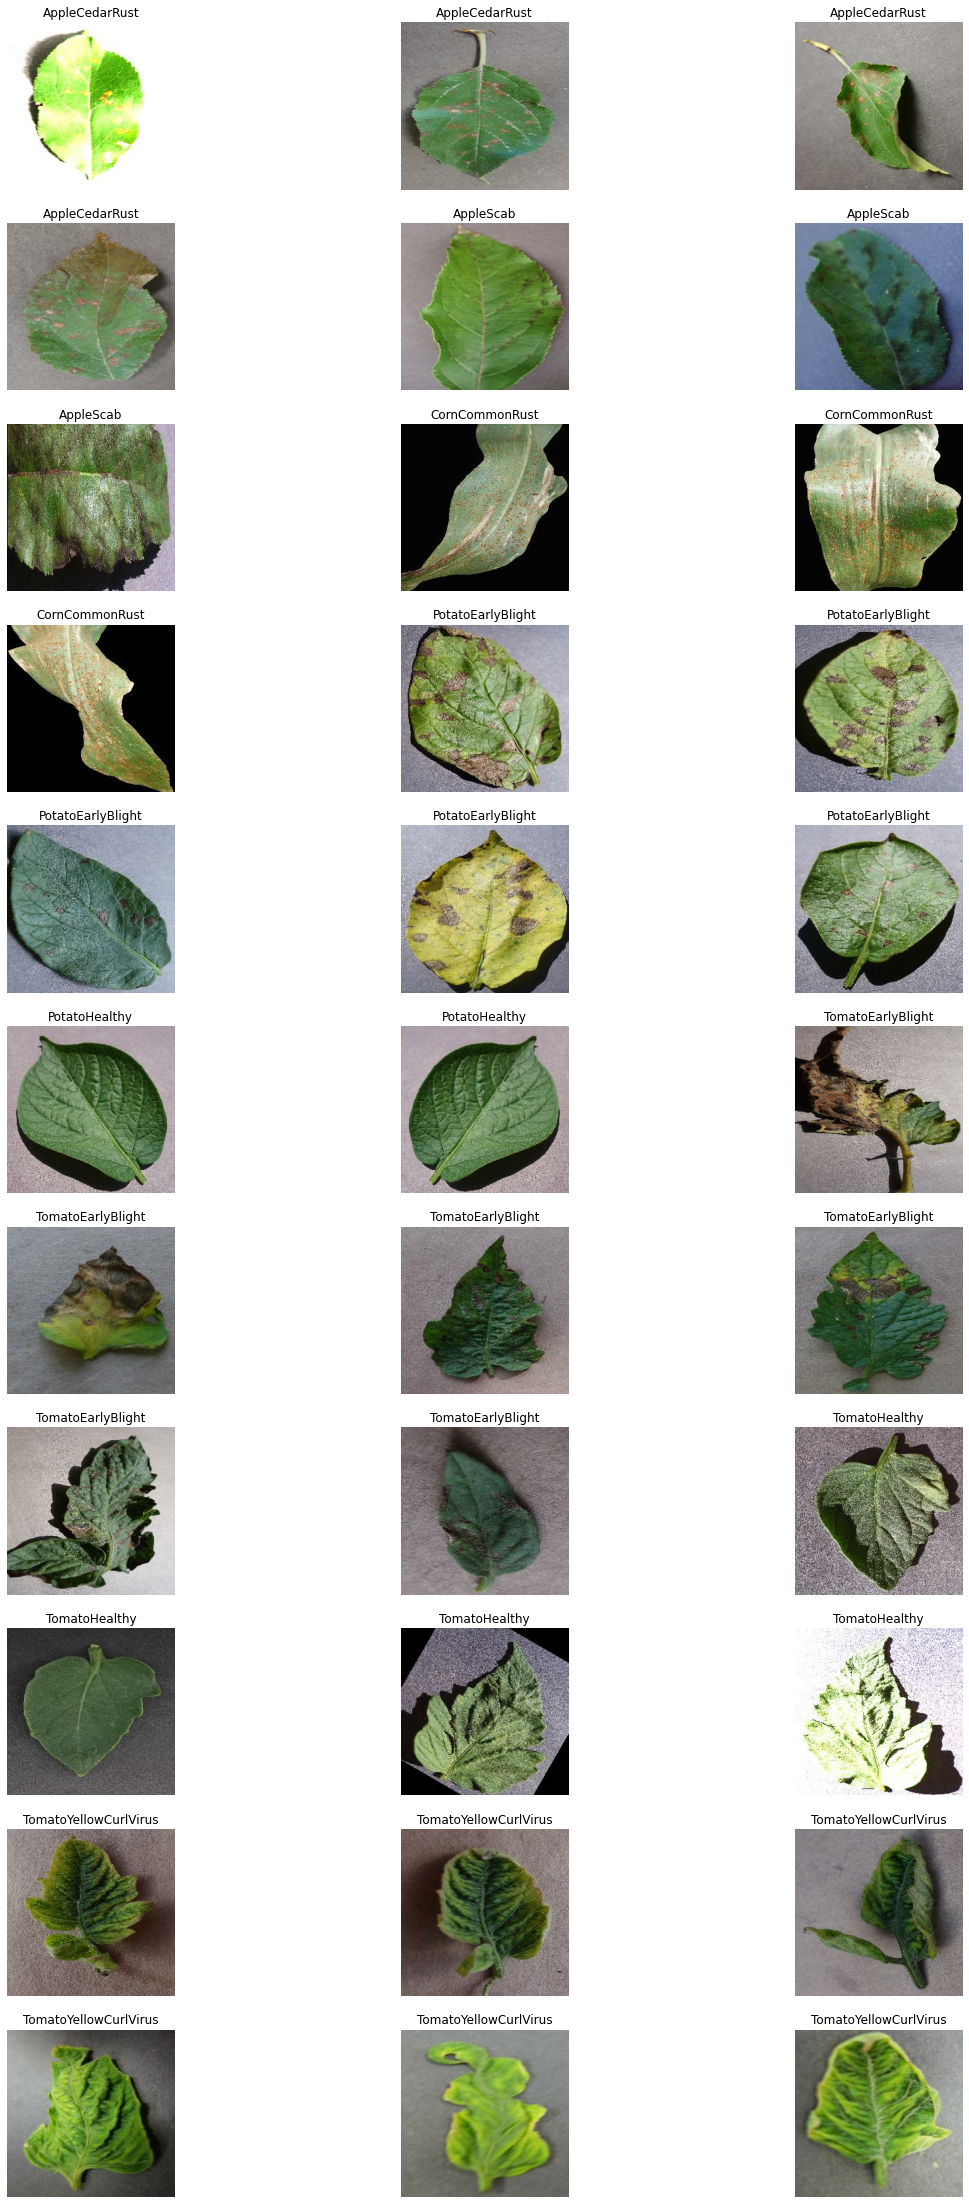

In [43]:
plt.figure(figsize=(20,40))
for images, labels in test_ds.take(1):
    for i in range(33):
        ax = plt.subplot(11, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().decode("utf-8"))
        plt.axis("off")

# Predictions on Test images provided in test directory

Since there are around 33 images all the images are tested

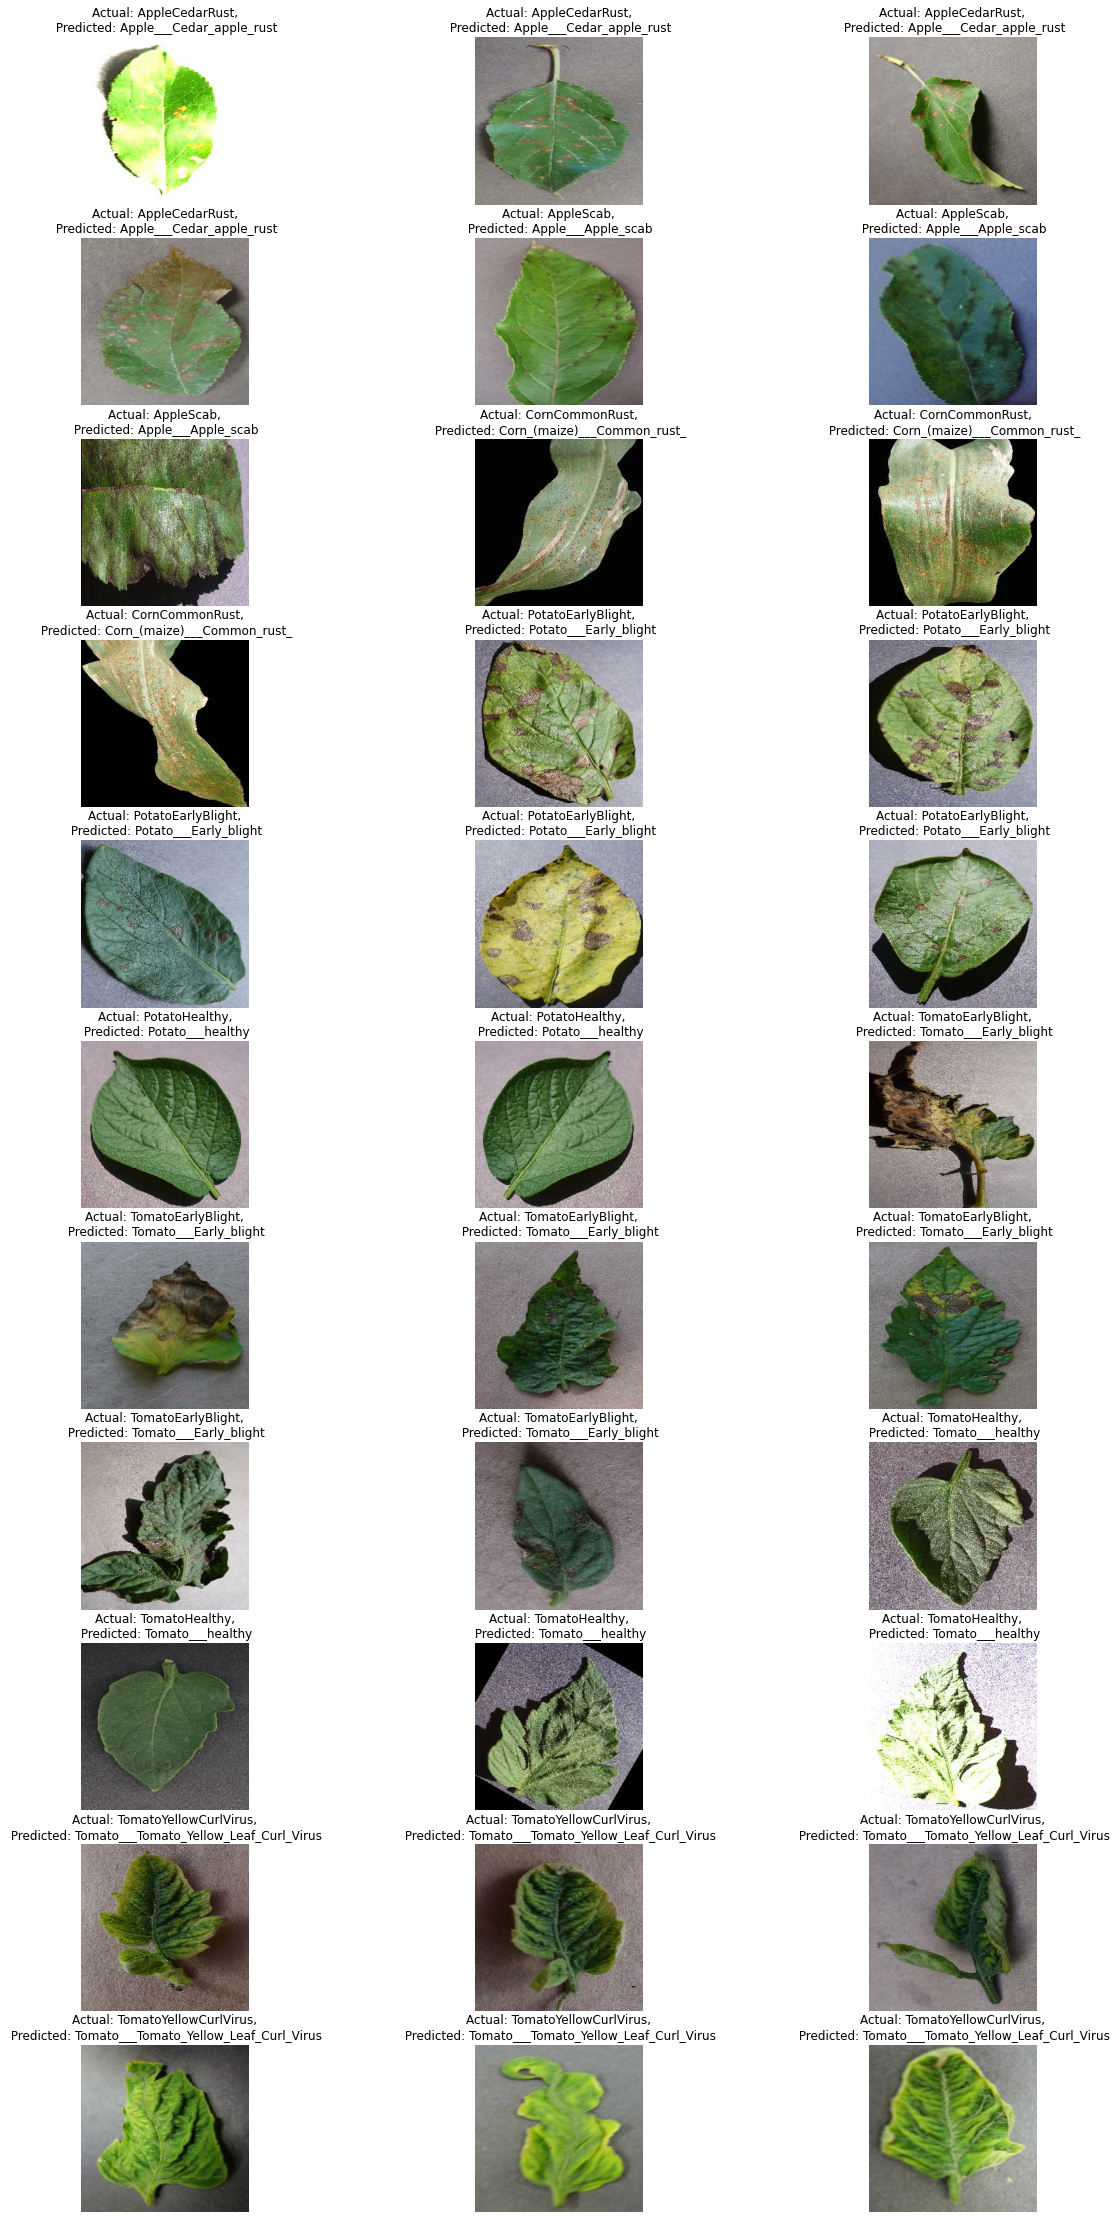

In [44]:
plt.figure(figsize=(20, 40))
for images, labels in test_ds.take(1):
    for i in range(33):
        ax = plt.subplot(11, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class = labels[i].numpy().decode("utf-8")
        
        img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_arr = tf.expand_dims(img_arr, 0)
        
        batch_prediction = resnet9.predict(img_arr)
        predicted_class = train_class_names[np.argmax(batch_prediction[0])]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        plt.axis("off")


# Saving the Model

- An entire model can be saved in two different file formats (**SavedModel** and HDF5). The TensorFlow SavedModel format is the default file format in TF2.x.
- **SavedModel** is convinient way for saving custom models and custom Layers.

In [45]:
resnet9.save('/kaggle/working/')